In [1]:
result = [[i+j for j in range(5)] for i in range(0, 45, 5)]

# Print the result
print(result)

[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9], [10, 11, 12, 13, 14], [15, 16, 17, 18, 19], [20, 21, 22, 23, 24], [25, 26, 27, 28, 29], [30, 31, 32, 33, 34], [35, 36, 37, 38, 39], [40, 41, 42, 43, 44]]


In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
from scipy.stats import pearsonr
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import HighLevelFeatures as HLF

In [2]:
def file_read(file_name):
    with h5py.File(file_name, "r") as h5f:
        e = h5f['incident_energies'][::].astype(np.float32)  
        shower = h5f['showers'][::].astype(np.float32)
        
    return e, shower

In [3]:
file_ds2='/scratch/fa7sa/IJCAI_experiment/dataset_2/dataset_2_2.hdf5'
e,shower=file_read(file_ds2)
print(e.shape,shower.shape)
file2='/scratch/fa7sa/CaloDiffusionPaper/scripts/test_ds2_100000.h5'
e2,shower2=file_read(file2)
file3='/scratch/fa7sa/CaloINN/results/20240320_101824_eplus_good/samples.hdf5'
e3,shower3=file_read(file3)

(100000, 1) (100000, 6480)


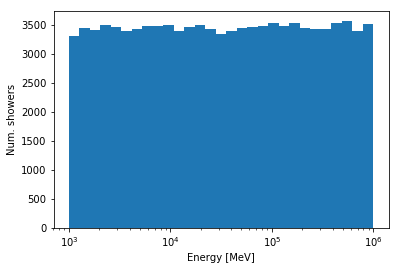

In [4]:
bins = np.logspace(3,6,30)
plt.hist(e, bins=bins)
plt.xscale('log')
plt.xlabel('Energy [MeV]')
plt.ylabel('Num. showers')
plt.show()

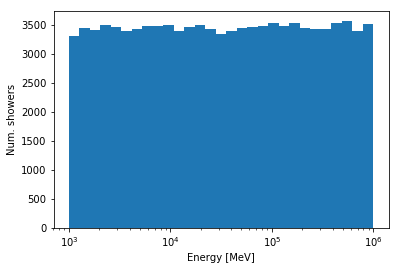

In [5]:
bins = np.logspace(3,6,30)
plt.hist(e2, bins=bins)
plt.xscale('log')
plt.xlabel('Energy [MeV]')
plt.ylabel('Num. showers')
plt.show()

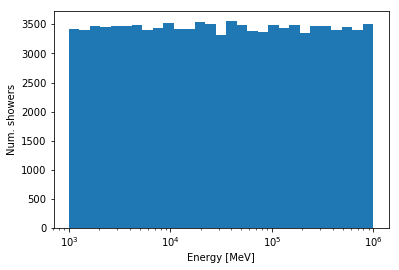

In [6]:
bins = np.logspace(3,6,30)
plt.hist(e3, bins=bins)
plt.xscale('log')
plt.xlabel('Energy [MeV]')
plt.ylabel('Num. showers')
plt.show()

In [44]:
min(e3)

array([1000.0349], dtype=float32)

In [11]:
#1 GeV to 1 TeV
target_energies = 10**np.linspace(3, 6, 4)
print(target_energies)


[   1000.   10000.  100000. 1000000.]


In [35]:
def _separation_power(hist1, hist2, bins):
    """ computes the separation power aka triangular discrimination (cf eq. 15 of 2009.03796)
        Note: the definition requires Sum (hist_i) = 1, so if hist1 and hist2 come from
        plt.hist(..., density=True), we need to multiply hist_i by the bin widhts
    """
    hist1, hist2 = hist1*np.diff(bins), hist2*np.diff(bins)
    ret = (hist1 - hist2)**2
    ret /= hist1 + hist2 + 1e-16
    return 0.5 * ret.sum()



min_energy=0.5e-6/0.033
x_scale='log'
def plot_E_group_layers_(hlf_class, reference_class,hlf_class_2,name):
    """ plots energy deposited in 5 consecutive layers by creating a group of 5 layers"""
    # this is only applicable for dataset 2 and dataset 3. Dataset 1 does not need this
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    fig.text(0.5, 0.0, 'E_inc of '+name, ha='center', fontsize=20)
    
    keys = [[i+j for j in range(5)] for i in range(0, 45, 5)]
    axs = axs.flatten()
    #pp=reference_class.GetElayers()[0].shape[0]
    for i,key in enumerate(keys):
        shape_a=reference_class.GetElayers()[0].shape[0]
        
        selected_ref = [reference_class.GetElayers()[i].reshape(shape_a,1)/1000 for i in key]#turning into GeV
        combined_ref = np.concatenate(selected_ref, axis=1)
        #print("Shape of combined array:", combined_ref.shape)
        mean_ref = np.mean(combined_ref, axis=1, keepdims=True) 
        #print("mean_ref",mean_ref.shape)
        #print(hlf_class.GetElayers().keys())
        shape_b=hlf_class.GetElayers()[0].shape[0]
        selected_hlf=[hlf_class.GetElayers()[i].reshape(shape_b,1)/1000 for i in key]#turning into GeV
        combined_hlf = np.concatenate(selected_hlf, axis=1)
        mean_hlf = np.mean(combined_hlf, axis=1, keepdims=True) 
        
        shape_c=hlf_class_2.GetElayers()[0].shape[0]
        selected_hlf_2=[hlf_class_2.GetElayers()[i].reshape(shape_c,1)/1000 for i in key]#turning into GeV
        combined_hlf_2 = np.concatenate(selected_hlf_2, axis=1)
        mean_hlf_2 = np.mean(combined_hlf_2, axis=1, keepdims=True) 
        
        
        
        
        
        if x_scale == 'log':
            #min_energy=
            bins = np.logspace(np.log10(min_energy),
                               np.log10(mean_ref.max()),
                               40)
        else:
            bins = 40
            
            
            
        counts_ref, bins, _ = axs[i].hist(mean_ref, bins=bins,
                                       label='Geant4', density=True, histtype='step',color='black',
                                       alpha=0.2, linewidth=3.)
        counts_data, _, _ = axs[i].hist(mean_hlf, label='Calodiff', bins=bins,
                                     histtype='step',color='salmon', linewidth=3., alpha=1., density=True)
        
        counts_data_2, _, _ = axs[i].hist(mean_hlf_2, label='CaloINN', bins=bins,
                                     histtype='step',color='green', linewidth=3., alpha=1., density=True)
        
        axs[i].set_title("layer {} to {}".format(key[0],key[4]))
        axs[i].set_xlabel(r'$E$ [GeV]')
        axs[i].set_yscale('log')
        axs[i].set_xscale('log')
        #plt.legend(fontsize=20)
        axs[i].legend(['Geant4 (dataset 2)','CaloDiff','CaloINN'],fontsize=12,prop={'size': 10},loc='upper right', bbox_to_anchor=(1.0, 1.0))
        test1=_separation_power(counts_ref, counts_data, bins)
        test2=_separation_power(counts_ref, counts_data_2, bins)
        
#         with open('histogram_chi2_{}.txt'.format(2),
#                   'a') as f:
#             f.write("separation power between (Geant4 and CaloDiff) is {} and (Geant4 and CaloINN)is {} for layer {} to {} where E_inc is".format(test1,test2,key[0],key[4],name))

#             f.write('\n\n')

        print("separation power between (Geant4 and CaloDiff) is {} and (Geant4 and CaloINN)is {} for layer {} to {}".format(test1,test2,key[0],key[4]))

    plt.tight_layout(pad=3.0)
    

    filename =  'E_layers_dataset_{}_{}.pdf'.format(
        2,name)
        #, dpi=300
    plt.savefig(filename,dpi=300)

    plt.close()
    
    

In [14]:
#from evaluate_plotting_helper import *

binning_file="/scratch/fa7sa/IJCAI_experiment/homepage/code/binning_dataset_2.xml"
particle='electron'
hlf = HLF.HighLevelFeatures(particle,binning_file)
ref_hlf=HLF.HighLevelFeatures(particle,binning_file)
ref_hlf.Einc=e
hlf.Einc=e2
ref_hlf.CalculateFeatures(shower)
hlf.CalculateFeatures(shower2)


In [23]:
plot_E_group_layers_(hlf,ref_hlf,name="all")

mean_ref (100000, 1)
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44])
mean_ref (100000, 1)
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44])
mean_ref (100000, 1)
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44])
mean_ref (100000, 1)
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44])
mean_ref (100000, 1)
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41

In [36]:

# for each loop new kore ekekta class create kori.



for i in range(len(target_energies)-1):
    
    hlf = HLF.HighLevelFeatures(particle,binning_file)
    hlf_2=HLF.HighLevelFeatures(particle,binning_file)
    ref_hlf=HLF.HighLevelFeatures(particle,binning_file)
    filename = str(target_energies[i]/1000)+'GeV to <'+str(target_energies[i+1]/1000)+' GeV'
    which_showers = ((e >= target_energies[i]) & \
                     (e < target_energies[i+1])).squeeze()
    ref_hlf.Einc=e[which_showers]
    ref_hlf.CalculateFeatures(shower[which_showers])
    

    # print(which_showers.shape)
    # print(shower[which_showers].shape)
    
    
    which_showers_1=((e2 >= target_energies[i]) & \
                     (e2 < target_energies[i+1])).squeeze()
    hlf.Einc=e2[which_showers_1]
    hlf.CalculateFeatures(shower2[which_showers_1])
    # print(which_showers_1.shape)
    # print(shower2[which_showers_1].shape)
    
    
    which_showers_2=((e3 >= target_energies[i]) & \
                     (e3 < target_energies[i+1])).squeeze()
    hlf_2.Einc=e3[which_showers_2]
    hlf_2.CalculateFeatures(shower3[which_showers_2])
    
    plot_E_group_layers_(hlf,ref_hlf,hlf_2,name=filename)
    
    
    
    
    

#     if reference_hlf.E_tot is None:
#         reference_hlf.CalculateFeatures(reference_shower[which_showers])

#     print("Calculating high-level features for histograms: DONE.\n")

#     plot_test(hlf,reference_hlf,args,filename)

print("done testing...")


separation power between (Geant4 and CaloDiff) is 0.00142770875659294 and (Geant4 and CaloINN)is 0.09872512742938437 for layer 0 to 4
separation power between (Geant4 and CaloDiff) is 0.0016450463657536815 and (Geant4 and CaloINN)is 0.02202911039774779 for layer 5 to 9
separation power between (Geant4 and CaloDiff) is 0.0027218291161286642 and (Geant4 and CaloINN)is 0.07057526976566982 for layer 10 to 14
separation power between (Geant4 and CaloDiff) is 0.0026625041465853758 and (Geant4 and CaloINN)is 0.0680575860484981 for layer 15 to 19
separation power between (Geant4 and CaloDiff) is 0.004607716020364513 and (Geant4 and CaloINN)is 0.02905975814207906 for layer 20 to 24
separation power between (Geant4 and CaloDiff) is 0.00947634433510152 and (Geant4 and CaloINN)is 0.01220943107188537 for layer 25 to 29
separation power between (Geant4 and CaloDiff) is 0.012861795248705218 and (Geant4 and CaloINN)is 0.022284417094743672 for layer 30 to 34
separation power between (Geant4 and CaloDif

In [37]:
# for the whole dataset.
filename='all'
hlf = HLF.HighLevelFeatures(particle,binning_file)
hlf_2=HLF.HighLevelFeatures(particle,binning_file)
ref_hlf=HLF.HighLevelFeatures(particle,binning_file)

ref_hlf.Einc=e
ref_hlf.CalculateFeatures(shower)

hlf.Einc=e2
hlf.CalculateFeatures(shower2)


hlf_2.Einc=e3
hlf_2.CalculateFeatures(shower3)
    
plot_E_group_layers_(hlf,ref_hlf,hlf_2,name=filename)

separation power between (Geant4 and CaloDiff) is 0.0004511843242095175 and (Geant4 and CaloINN)is 0.06431561161486653 for layer 0 to 4
separation power between (Geant4 and CaloDiff) is 0.0004920857057294889 and (Geant4 and CaloINN)is 0.019129614071720508 for layer 5 to 9
separation power between (Geant4 and CaloDiff) is 0.0006324147326040474 and (Geant4 and CaloINN)is 0.019925275978613908 for layer 10 to 14
separation power between (Geant4 and CaloDiff) is 0.0006432502969349854 and (Geant4 and CaloINN)is 0.02524438844941321 for layer 15 to 19
separation power between (Geant4 and CaloDiff) is 0.0010131349594278238 and (Geant4 and CaloINN)is 0.02173233769429525 for layer 20 to 24
separation power between (Geant4 and CaloDiff) is 0.0018427673634315981 and (Geant4 and CaloINN)is 0.020331330806339164 for layer 25 to 29
separation power between (Geant4 and CaloDiff) is 0.0018637490880717446 and (Geant4 and CaloINN)is 0.018847405528323428 for layer 30 to 34
separation power between (Geant4 a